In [1]:
import json
import os

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

In [2]:
def year_to_day(df: pd.DataFrame, cols=("value_kusd", "volume_tons")) -> pd.DataFrame:
    for col in cols:
        df[col] /= 365.24
    return df

In [3]:
def process_routes(routes: pd.DataFrame) -> pd.DataFrame:
    routes = year_to_day(routes)
    routes["value_USD_d"] = routes.value_kusd * 1_000
    routes["flow_cost_USD_d"] = routes.value_USD_d * routes.volume_tons
    routes["cost_and_value_USD_d"] = routes.value_USD_d + routes.flow_cost_USD_d
    return routes

In [4]:
plt.style.use("bmh")

root_dir = ".."

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

nominal_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/")
degraded_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/hazard-thai-floods-2011-JBA/")

nominal_edges = year_to_day(gpd.read_parquet(os.path.join(nominal_dir, "edges.gpq")))
degraded_edges = year_to_day(gpd.read_parquet(os.path.join(degraded_dir, "edges.gpq")))
    
nominal_routes = process_routes(pd.read_parquet(os.path.join(nominal_dir, "routes_with_costs.pq")))
degraded_routes = process_routes(pd.read_parquet(os.path.join(degraded_dir, "routes_with_costs.pq")))

/tmp/ipykernel_893056/1150984078.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


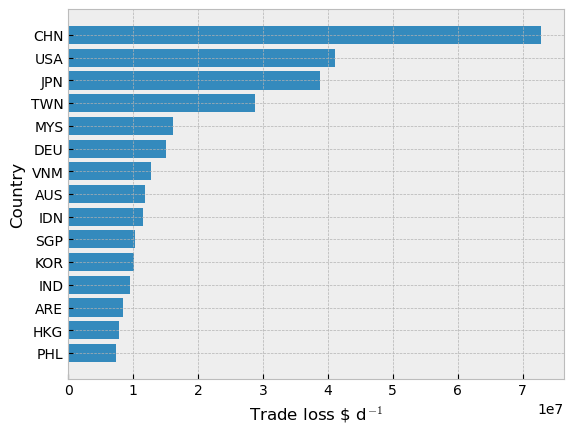

In [5]:
nominal = nominal_routes.loc[:, ["destination_node", "value_USD_d"]].groupby("destination_node")\
    .sum().rename(columns={"value_USD_d": "nominal"})
degraded = degraded_routes.loc[:, ["destination_node", "value_USD_d"]].groupby("destination_node")\
    .sum().rename(columns={"value_USD_d": "degraded"})
partner_value = nominal.join(degraded)
partner_value["abs_change_kusd"] = partner_value.nominal - partner_value.degraded
partner_value["perc_change"] = 100 * partner_value.abs_change_kusd / partner_value.nominal
top_change = partner_value.sort_values("abs_change_kusd", ascending=False).iloc[:15]
f, ax = plt.subplots()
ax.barh(top_change.index[::-1], top_change.abs_change_kusd[::-1])
ax.set_xlabel(r"Trade loss \$ d$^{-1}$")
ax.set_ylabel("Country")
f.savefig("trade_loss_by_country.png")

In [6]:
# fraction of trade value successfully routed given degraded network
def print_summary(nominal: pd.DataFrame, degraded: pd.DataFrame, var: str) -> None:
    print(var)
    print(f"nominal: {nominal[var].sum():.2E}")
    print(f"degraded {degraded[var].sum():.2E}")
    print(f"difference {nominal[var].sum() - degraded[var].sum():.2E}")
    fraction_lost = 1 - (degraded[var].sum() / nominal[var].sum())
    print(f"fraction_lost: {fraction_lost:.3f}")

print_summary(nominal_routes, degraded_routes, "value_USD_d")
print()
print_summary(nominal_routes, degraded_routes, "volume_tons")

value_USD_d
nominal: 1.44E+09
degraded 1.07E+09
difference 3.65E+08
fraction_lost: 0.253

volume_tons
nominal: 8.28E+05
degraded 6.24E+05
difference 2.05E+05
fraction_lost: 0.247


nominal: p90 = 49.55
degraded: p90 = 68.67


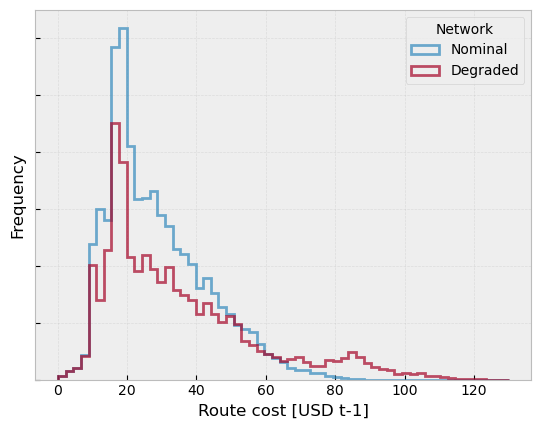

In [7]:
f, ax = plt.subplots()
alpha = 0.7
for colour, scenario, df in (('#348ABD', "nominal", nominal_routes), ('#A60628', "degraded", degraded_routes)): 
    df.cost_USD_t.hist(
        ax=ax,
        bins=np.linspace(0.1, 130, 60),
        alpha=alpha,
        label=f"{scenario.capitalize()}",# cost USD t-1",
        histtype="step",
        lw=2,
        color=colour
    )
    level = 0.9
    quantile = df.cost_USD_t.quantile(level)
    print(f"{scenario}: p{level * 100:.0f} = {quantile:.2f}")
ax.legend(title="Network")
ax.grid(alpha=0.3)
ax.set_yticklabels([])
ax.set_xlabel("Route cost [USD t-1]")
ax.set_ylabel("Frequency")
f.savefig("route_cost_comparison.png")

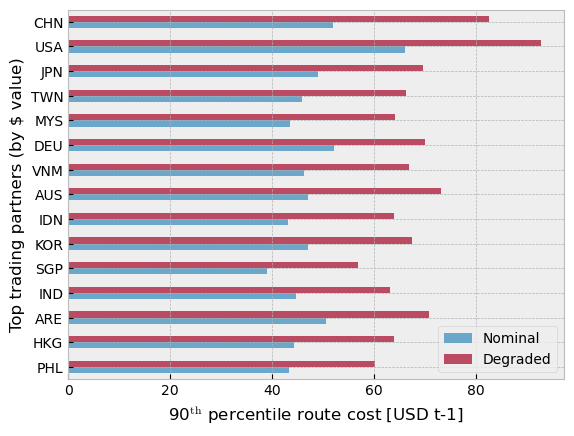

In [8]:
f, ax = plt.subplots()
n = 15
q_level = 0.9
top_countries = partner_value.sort_values("nominal", ascending=False).iloc[:n][::-1].index
by_country_nominal = nominal_routes.loc[:, ["destination_node", "cost_USD_t"]].groupby("destination_node").quantile(q_level)
by_country_degraded = degraded_routes.loc[:, ["destination_node", "cost_USD_t"]].groupby("destination_node").quantile(q_level)
to_plot = by_country_degraded.loc[top_countries, ["cost_USD_t"]].rename(columns={"cost_USD_t": "Degraded"}) \
    .join(by_country_nominal.loc[top_countries, ["cost_USD_t"]].rename(columns={"cost_USD_t": "Nominal"}))
to_plot.loc[:, ["Nominal", "Degraded"]].plot(kind="barh", ax=ax, alpha=0.7)
ax.set_ylabel("Top trading partners (by $ value)")
ax.set_xlabel(f"{100 * q_level:.0f}$^{{\mathrm{{th}}}}$ percentile route cost [USD t-1]")
ax.legend()
f.savefig(f"top_trading_partner_route_cost_q_{q_level}.png")

In [10]:
os.makedirs("plots/route_costs/", exist_ok=True)
n = 20
bins = np.linspace(0.1, 130, 60)
top_countries = partner_value.sort_values("nominal", ascending=False).iloc[:n].index
nominal_indexed_on_country = nominal_routes.set_index("destination_node")
degraded_indexed_on_country = degraded_routes.set_index("destination_node")
ymax = 0
for country in top_countries:
    frequencies, _ = np.histogram(nominal_indexed_on_country.loc[country, "cost_USD_t"], bins)
    ymax = np.max([ymax, np.max(frequencies)])

for country in top_countries:
    f, ax = plt.subplots()
    for colour, ls, scenario, df in (
        ('#348ABD', '-', "nominal", nominal_indexed_on_country),
        ('#A60628', '--', "degraded", degraded_indexed_on_country)
    ): 
        df.loc[country, "cost_USD_t"].hist(
            ax=ax,
            bins=bins,
            alpha=alpha,
            label=f"{scenario.capitalize()}",
            histtype="step",
            lw=1,
            ls=ls,
            color=colour,
        )
    ax.set_title(country)
    ax.grid(alpha=0.3)
    ax.set_yticklabels([])
    #ax.set_ylim(0, 1.1 * ymax)
    ax.set_xlabel("Route cost [USD t-1]")
    ax.set_ylabel("Frequency")
    ax.legend()
    f.savefig(f"plots/route_costs/{country}.png")
    plt.close(f)